plan-track

In [1]:
from trainer.trainer import CWPTT
import matplotlib.pyplot as plt
import numpy as np
import torch

n_debris = 8 # number of debris
# trainer, _ = CWPTT(n_debris, "cuda", safe_dist=1000, actor_hiddens=[512]*8, critic_hiddens=[512]*8) # `planTrackTrainer` instance
trainer, _ = CWPTT(n_debris, "cuda", f"../model/planTrack{n_debris}_2.ptd", safe_dist=1000) # `planTrackTrainer` instance

In [58]:
trainer.agent.load(f"../model/planTrack{n_debris}_3.ptd")

In [4]:
ptd = torch.load(f"../model/planTrack{n_debris}_2.ptd")
trainer.agent.actor.load_state_dict(ptd["p_net"])

<All keys matched successfully>

In [2]:
ptd = torch.load(f"../model/planTrack{n_debris}.ptd")
trainer.agent.tracker.load_state_dict(ptd["tracker"])

<All keys matched successfully>

Output()

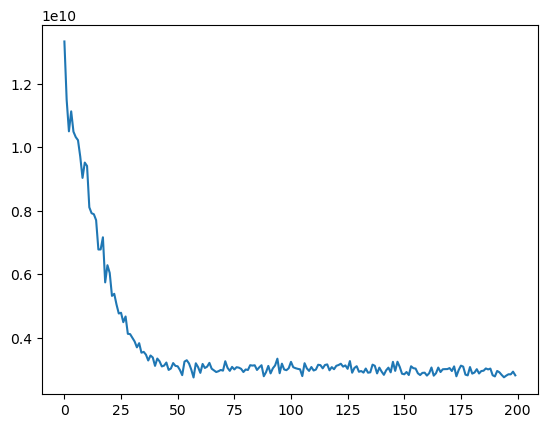

In [5]:
ll = trainer.trainTracker(1200, episode=200) # train tracker solely, mode-based
# trainer.agent.save(f"../model/planTrack{n_debris}.ptd")
plt.close("all")
plt.plot(ll) # loss
plt.show()

In [ ]:
# al, cl, tr, ar = trainer.trainPlanner(episode=1000, epoch=1, pertinence=False, explore_eps=1.) # train planner and critic, mode-free
al, cl, tr, ar = trainer.trainPlanner(episode=1000, epoch=10, pertinence=True, explore_eps=0.5) # train planner and critic, mode-free
# trainer.agent.save(f"../model/planTrack{n_debris}.ptd")
plt.close("all")
# plt.plot(tr) # total reward
# plt.show()
plt.plot(ar) # avoid rate
plt.show()

In [20]:
_, _, cl, tr = trainer.trainUnity(horizon=2400,)

Output()

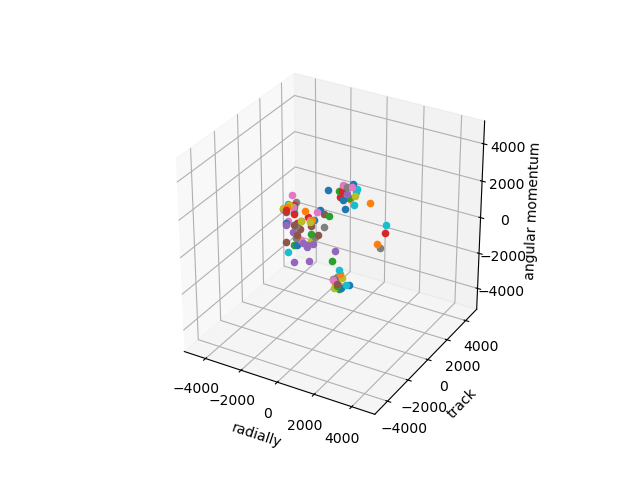

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
%matplotlib widget

n = 100

pp = None
pp = np.zeros((n,1,3))
states = trainer.mainProp.randomInitStates(n, pertinence_pos=pp)
obss = trainer.mainProp.getObss(states)
obss = torch.from_numpy(obss).float().to(trainer.agent.device)
_, targets_pos = trainer.agent.track_target(obss)
targets_pos = targets_pos.detach().cpu().numpy()

box_lim = 5000.
fig = plt.figure()
ax = fig.add_subplot(projection='3d', xlim=(-box_lim, box_lim), ylim=(-box_lim, box_lim), zlim=(-box_lim, box_lim))

for i in range(targets_pos.shape[0]):
    ax.scatter(targets_pos[i, 0], targets_pos[i, 1], targets_pos[i, 2], marker='o')

ax.set_aspect('equal')
ax.set_xlabel("radially")
ax.set_ylabel("track")
ax.set_zlabel("angular momentum")

pp = np.tile(targets_pos[:4], (100,1,1))

plt.show()

In [ ]:
from plotting.analyze import *
%matplotlib widget
horizon = 3600
d, stage = trainer.test(horizon, "mc", zero_pertinence=True) # test agent
plt.close('all')
n_debris = trainer.mainProp.n_debris
fig, _ = historyFile(d, agent=None, stage=stage, n_debris=n_debris, safe_dist=trainer.mainProp.safe_dist) # visualization

In [17]:
trainer.agent.save(f"../model/planTrack{n_debris}_u.ptd")

In [ ]:
N = 100
collision = 0
horizon = 2400
for i in range(N):
    d, stage = trainer.test(horizon, "static+", opt_step=20000)
    if stage<horizon-1:
        collision += 1
print(collision/N)

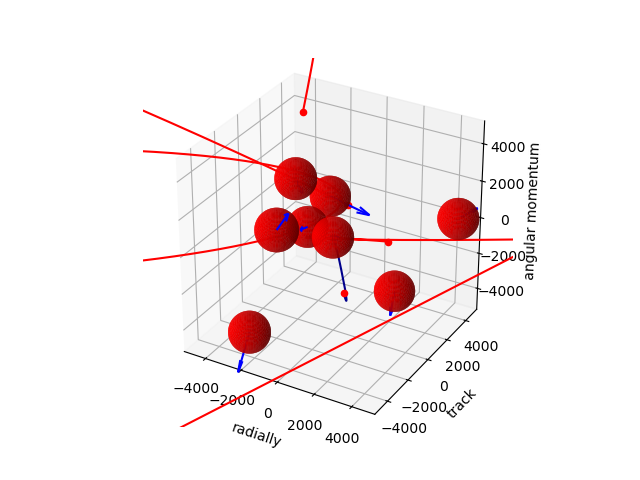

In [14]:
from plotting.trajplot import mulDeTrajPlot, mulDeSafeSpherePlot

decoded = trainer.mainProp.statesDecode(d["states"][:1])
decoded["debris"][:,:, :3] = decoded["forecast_pos"][:]
decoded["debris"][:,:,3:6] = decoded["forecast_vel"][:]
decoded["forecast_time"][...] = 0
xs = trainer.mainProp.statesEncode(decoded)[:,:6*(n_debris+1)]

plt.close("all")
step = 1800
x = d["states"][:step,:6*(n_debris+1)]
ax, _ = mulDeTrajPlot(x, box_lim=trainer.mainProp.max_dist)
ax, _ = mulDeSafeSpherePlot(xs, ax=ax, rad=trainer.mainProp.safe_dist)

In [ ]:
from anime.anime import trajAni
plt.close("all")
x = d["states"][:,:6*(n_debris+1)]
ani = trajAni(x, box_lim=2000.)
# ani.save("traj.gif", writer="pillow")

In [42]:
num = 7
pp = np.zeros((1,num,6))
pp[:,:,-1] = np.linspace(-1,1,num)
pp *= trainer.mainProp.max_dist
pp[:,:,:-1] = (np.random.rand(num,1)-1/2)*2*200

In [16]:
num = 7
pp = np.zeros((1,num,6))
pp[:,:,:2] = (np.random.rand(num,2)-1/2)*2
pp[:,0,:] = 0.
pp *= trainer.mainProp.max_dist
pp[:,:,-1:] = (np.random.rand(num,1)-1/2)*2*200

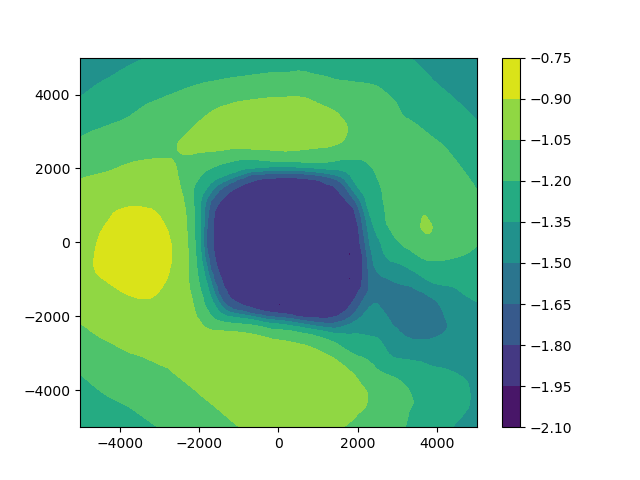

In [17]:
import numpy as np
from plotting import analyze
import torch
%matplotlib widget

opt_step = 1000
pace = 100
log_point = np.arange(0, opt_step, pace)
target_path = []

mc_num = 100

s = trainer.mainProp.randomInitStates(1, 
                                      pertinence_states = pp
                                      )
decoded = trainer.mainProp.statesDecode(s)
fp = decoded["forecast_pos"]

def foo_plot(states:np.ndarray, axis:np.ndarray):

    o = trainer.mainProp.getObss(s)
    o_a = np.hstack((o.flatten(), np.zeros(trainer.agent.control_dim)))

    n_f = trainer.agent.critic.n_feature
    dims = n_f-(3-axis)
    o_a_ = np.delete(o_a, dims)


    # plt.close("all")
    analyze.criticContour(trainer.agent, span=(-5000,5000), dims=dims, step=101, singles=o_a_) # contour plot of critic in selected dims

    obs = torch.from_numpy(o).float().to(trainer.agent.device)

    target0 = trainer.agent.planner(obs)

    noise = torch.randn(mc_num, 3)*trainer.mainProp.max_dist/6
    noise = noise.to(trainer.agent.device)
    target_mc = target0 + noise

    # target = torch.tensor(target0, requires_grad=True)
    # plans_opt = torch.optim.Adam([target], lr=1e2)
    # for i in range(opt_step):
    #     Qs = trainer.agent.critic(obs, target)
    #     loss = -Qs.mean()
    #     plans_opt.zero_grad()
    #     loss.backward()
    #     plans_opt.step()
    #     if i in log_point or i==opt_step-1:
    #         target_path.append(target.detach().cpu().numpy().flatten())
    # tp = np.vstack(target_path)
    # target = target.detach().cpu().numpy().flatten()
    # _ = plt.scatter(*tp[:,axis].transpose(), c="orange", marker="^") # planner's output
    # _ = plt.scatter(*target[axis], c="r", marker="o") # planner's output

    obs_mc = torch.tile(obs, (mc_num, 1))
    Q_mc = trainer.agent.critic(obs_mc, target_mc)
    idx = Q_mc.argmax()
    target_mc = target_mc.detach().cpu().numpy()
    target0 = target0.detach().cpu().numpy()
    best_target = target_mc[idx]

    # _ = plt.scatter(*target_mc[:,axis].transpose(), c="orange")
    _ = plt.scatter(*best_target[axis], c="r")
    _ = plt.scatter(*fp[0,:,axis], c="yellow")
    _ = plt.scatter(*target0[:,axis].transpose(), c="purple")

plt.close("all")
_axis = np.array([0,1,2])
i = 2
axis = np.delete(_axis, i)
foo_plot(s, axis)

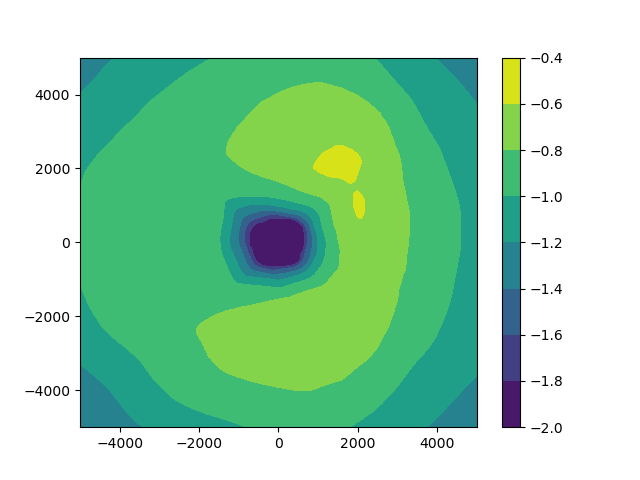

In [89]:
plt.close("all")
_axis = np.array([0,1,2])
i = 1
axis = np.delete(_axis, i)
foo_plot(s, axis)

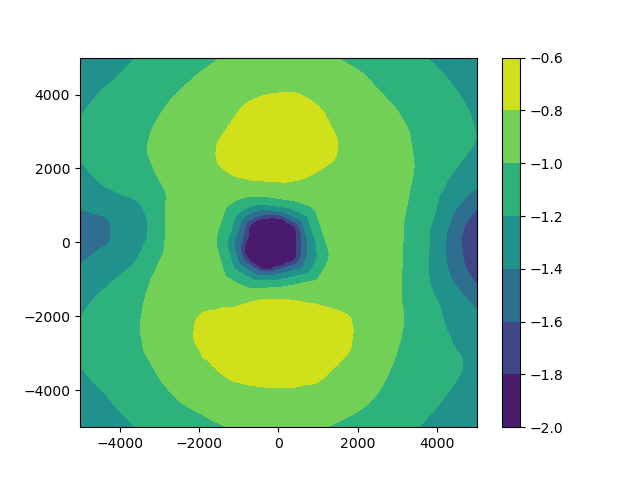

In [90]:
plt.close("all")
_axis = np.array([0,1,2])
i = 0
axis = np.delete(_axis, i)
foo_plot(s, axis)

模仿学习

In [2]:
from env.propagators.hierarchicalPropagator import impulsePropagator
import torch
import numpy as np
import matplotlib.pyplot as plt

impulse_bound = 0.1
n_debris = 3
prop = impulsePropagator(n_debris, device="cuda", h1_step=30, h2_step=120, 
                         impulse_bound=impulse_bound, safe_dist=2000.)
batch_size = 320
max_loop = 15
impulse_num = 20

from agent.net import boundedFcNet, boundedLSTM, ballFcNet
upper_bounds = [ impulse_bound]*3
lower_bounds = [-impulse_bound]*3
# actor = boundedFcNet(prop.obs_dim, 3, [512]*4, 
#                      upper_bounds=upper_bounds, 
#                      lower_bounds=lower_bounds).to("cuda")
# actor = boundedLSTM(prop.obs_dim, 3, 128, 12, [512]*3, 
#                     upper_bounds=upper_bounds, 
#                     lower_bounds=lower_bounds).to("cuda")
actor = ballFcNet(prop.obs_dim, 3, [512]*8, impulse_bound).to("cuda")
opt1 = torch.optim.Adam(actor.parameters(), lr=0.001)

In [ ]:
# make data
from data.loader import npzLoader
feature = []
label = []
for epoch in range(40):
    s0 = prop.randomInitStates(batch_size)
    imp, best_i, rewards = prop.best_impulses(s0, max_loop=max_loop, impulse_num=impulse_num)
    best_imp = torch.zeros((imp.shape[0], imp.shape[2], imp.shape[3]), device=imp.device)
    for i in range(batch_size):
        best_imp[i,...] = imp[i,best_i[i],...]
    best_imp_ = best_imp.transpose(0,1)

    td1, td2, _ = prop.impulses_test(s0, best_imp)

    feature.append(td1["obss"].detach().cpu())
    label.append(best_imp_.detach().cpu())
feature = torch.cat(feature, dim=1)
label = torch.cat(label, dim=1)
loader = npzLoader.make("../model/sv/data.npz", feature=feature, label=label)

In [6]:
from data.loader import npzLoader
i = 1
loader = npzLoader(f"../model/sv/data{i}.npz")
feature, label = loader.torch(actor.device)

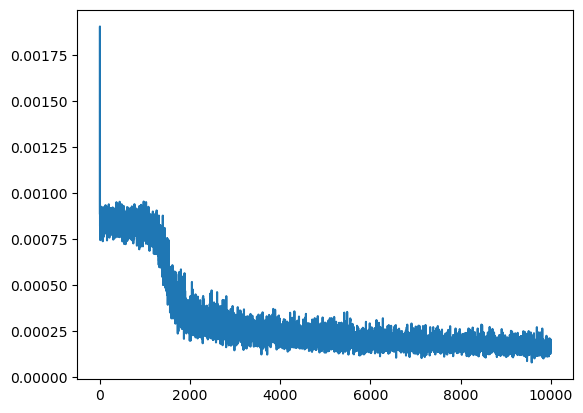

In [3]:
loss_list = []
total = feature.shape[1]
mini_batch = 64
epoch = 10000
for j in range(epoch):
    idx = np.random.choice(total, mini_batch, replace=False)
    obss = feature[:, idx].to(actor.device)
    out = actor(obss)
    loss = torch.nn.functional.mse_loss(label[:,idx].to(actor.device), out, reduction='mean')
    opt1.zero_grad()
    loss.backward()
    opt1.step()
    loss_list.append(loss.item())
plt.plot(loss_list[:])
plt.show()

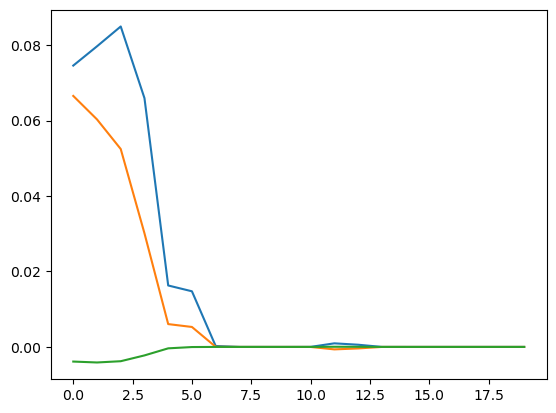

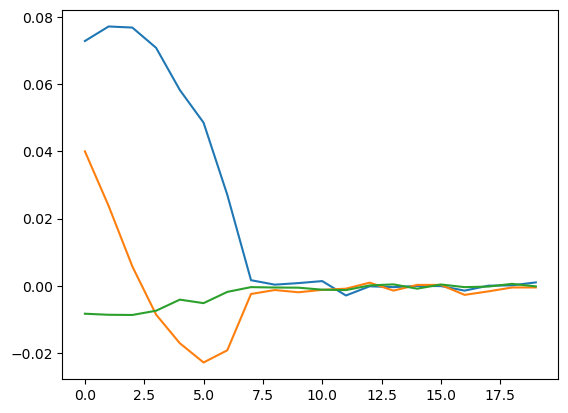

In [94]:
idx = np.random.randint(0, feature.shape[1])

obss = feature[:,idx].to(actor.device)
out = actor(obss)

# check gradient vanishing
# opt1.zero_grad()
# loss = torch.abs(out).mean()
# loss.backward()
# g = [p.grad for p in actor.parameters()]
# print(g)

plt.plot(out[:].detach().cpu().numpy())
plt.show()
plt.plot(label[:,idx].detach().cpu().numpy())
plt.show()

Output()

d:\code\workshop\genetic tree search\env\propagators\hierarchicalPropagator.py:698: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _impulses = torch.tensor(_impulses, requires_grad=True, device=self.device)


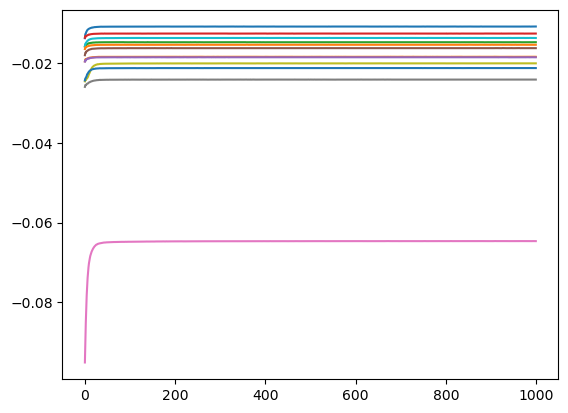

In [48]:
bs = 12
s0 = prop.randomInitStates(bs)
imp, best_i, rewards = prop.best_impulses(s0, population=400, max_loop=1000, impulse_num=impulse_num)
best_imp = torch.zeros((imp.shape[0], imp.shape[2], imp.shape[3]), device=imp.device)
for i in range(bs):
    best_imp[i,...] = imp[i,best_i[i],...]
plt.plot(rewards.transpose(0,1).detach().cpu().numpy())
plt.show()

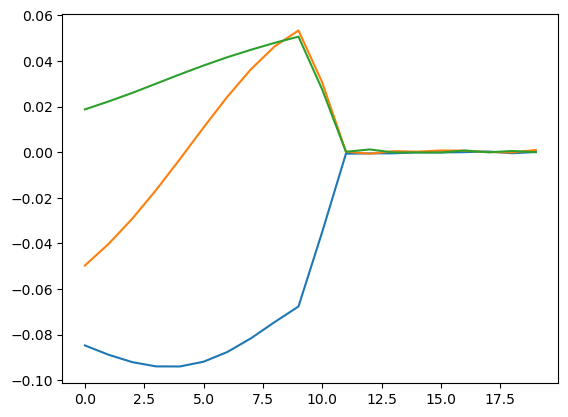

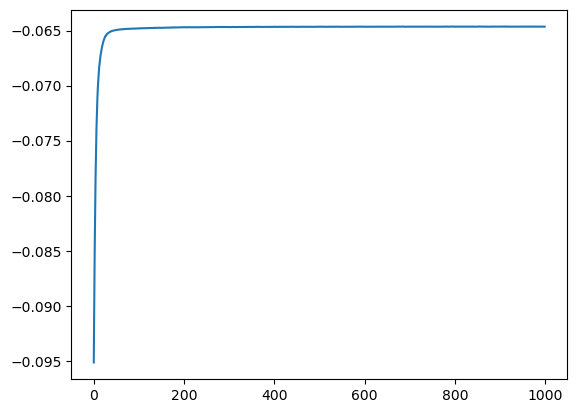

In [64]:
i = np.random.randint(0, len(best_imp))
plt.plot(best_imp[i].detach().cpu().numpy())
plt.show()
plt.plot(rewards[i].detach().cpu().numpy())
plt.show()

In [95]:
s0 = prop.randomInitStates(batch_size)
imp, best_i, rewards = prop.best_impulses(s0, max_loop=max_loop, impulse_num=impulse_num)
best_imp = torch.zeros((imp.shape[0], imp.shape[2], imp.shape[3]), device=imp.device)
for i in range(batch_size):
    best_imp[i,...] = imp[i,best_i[i],...]
td1_best, td2_best, rewards_best = prop.impulses_test(s0, best_imp)
td1, td2, rewards = prop.impulses_test_actor(s0, actor, impulse_num=impulse_num)

print(rewards_best.mean().item(), rewards.mean().item())
print(rewards_best.min().item(),  rewards.min().item())

Output()

d:\code\workshop\genetic tree search\env\propagators\hierarchicalPropagator.py:693: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _impulses = torch.tensor(_impulses, requires_grad=True, device=self.device)


-0.023745914921164513 -0.02379894070327282
-0.0661567822098732 -0.07730625569820404


In [19]:
s0 = prop.randomInitStates(batch_size)
td1, td2, rewards = prop.impulses_test_actor(s0, actor, impulse_num=impulse_num)

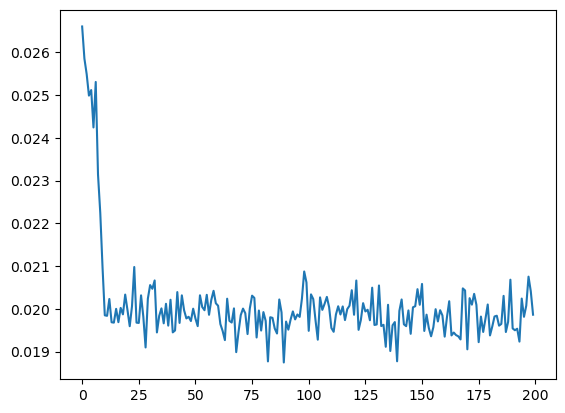

In [15]:
L = []
for _ in range(200):
    td1, td2, rewards = prop.actor_opt(actor, batch_size=batch_size, impulse_num=impulse_num)
    loss = -rewards.mean()
    opt1.zero_grad()
    loss.backward()
    opt1.step()
    L.append(loss.item())
plt.plot(L)
plt.show()

In [4]:
torch.save(actor.state_dict(), "../model/sv/actor_rl_ball.pt")

In [ ]:
sd = torch.load("../model/sv/actor_rl.pt")
actor.load_state_dict(sd)